### I. Implementieren Sie einen CollisionChecker, der es erlaubt, einen holonomen „mobilen“ Roboter mit 2 (x, y) bzw. 3 Freiheitsgraden (x, y, rot z) und Hindernissen mit den Planungsverfahren aus der Vorlesung zu planen, ohne dass die Planungsverfahren verändert werden müssen.

### a) Erläutern Sie, was „holonom“ in diesem Kontext bedeutet

Ein **holonomes System** ist ein System, bei dem die Anzahl der **steuerbaren Freiheitsgrade (Degrees of Freedom, DoF)** der Anzahl der **konfigurationsbeschreibenden Freiheitsgrade** entspricht.

Mit anderen Worten:  
Ein **Roboter ist holonom**, wenn er sich **jederzeit in alle Richtungen des Konfigurationsraums bewegen kann**, die durch seine mechanische Konfiguration erlaubt sind.

#### Im Kontext des Aufgabenblatts bedeutet das konkret:

- Ein **2-DoF mobiler Roboter** hat die Steuergrößen:
  - `x`: Translation entlang der x-Achse  
  - `y`: Translation entlang der y-Achse  

- Ein **3-DoF mobiler Roboter** hat die Steuergrößen:
  - `x`: Translation entlang der x-Achse  
  - `y`: Translation entlang der y-Achse  
  - `θ`: Rotation um die Hochachse (z-Achse)

Ein solcher Roboter kann sich also **unabhängig und direkt entlang jeder dieser Freiheitsgrade bewegen**, ohne Einschränkungen durch sogenannte **nicht-holonome Zwangsbedingungen** (wie etwa bei einem Auto, das nicht seitlich fahren kann).


In [ ]:
from HelperFunction import SceneBuilder, update_scene
from shapely.geometry import Polygon, Point
import ipywidgets as widgets

# Szene anlegen und Hindernisse hinzufügen
scene = SceneBuilder()
scene.add_obstacle('wall', Polygon([(2,2),(18,2),(18,3),(2,3)]))
scene.add_obstacle('pillar', Point(10,10).buffer(1.5))

# Interaktive Darstellung
slider = widgets.IntSlider(value=5, min=1, max=99, step=1, description='Anzahl:')
widgets.interact(lambda n: update_scene(scene, n), n=slider)


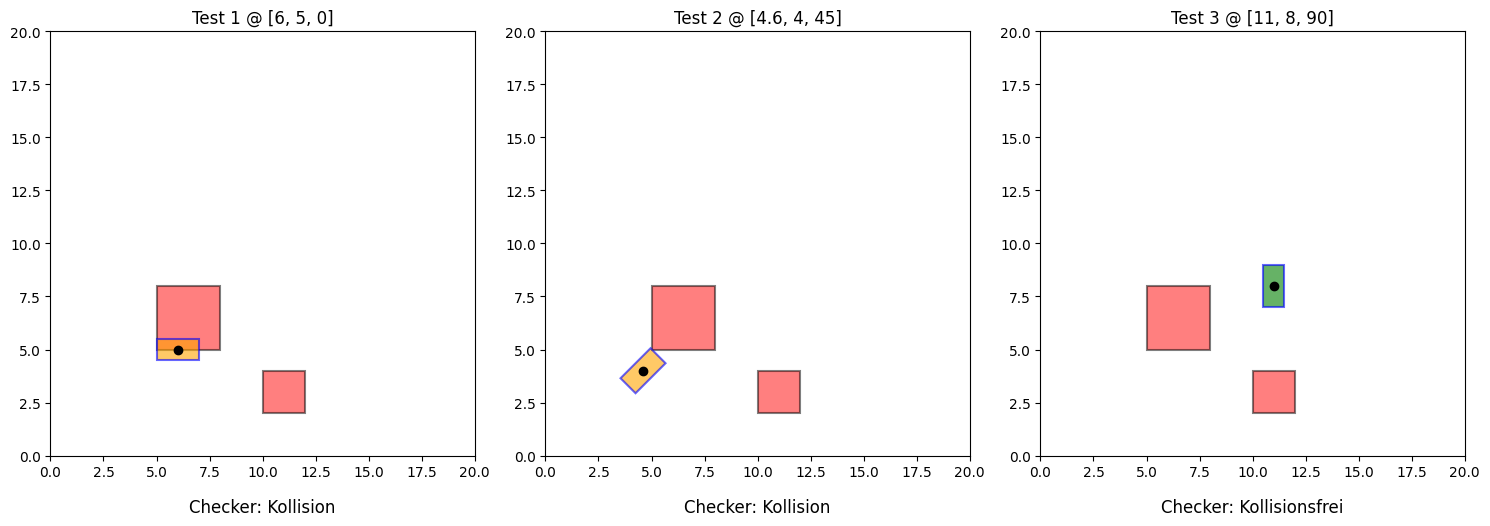

In [8]:
from HelperFunction import SceneBuilder, plot_collision_tests
from shapely.geometry import box
from IPMobileRobotCollisionChecker import MobileRobotCollisionChecker

# Setup
robot_shape = box(-1, -0.5, 1, 0.5)
scene = {"obstacle1": box(5,5,8,8), "obstacle2": box(10,2,12,4)}
checker = MobileRobotCollisionChecker(robot_shape, scene, limits=[[0,20],[0,20],[0,360]])
tests = [([6,5,0], "Test 1"), ([4.6,4,45], "Test 2"), ([11,8,90], "Test 3")]

# Aufruf
plot_collision_tests(robot_shape, scene, checker, tests)


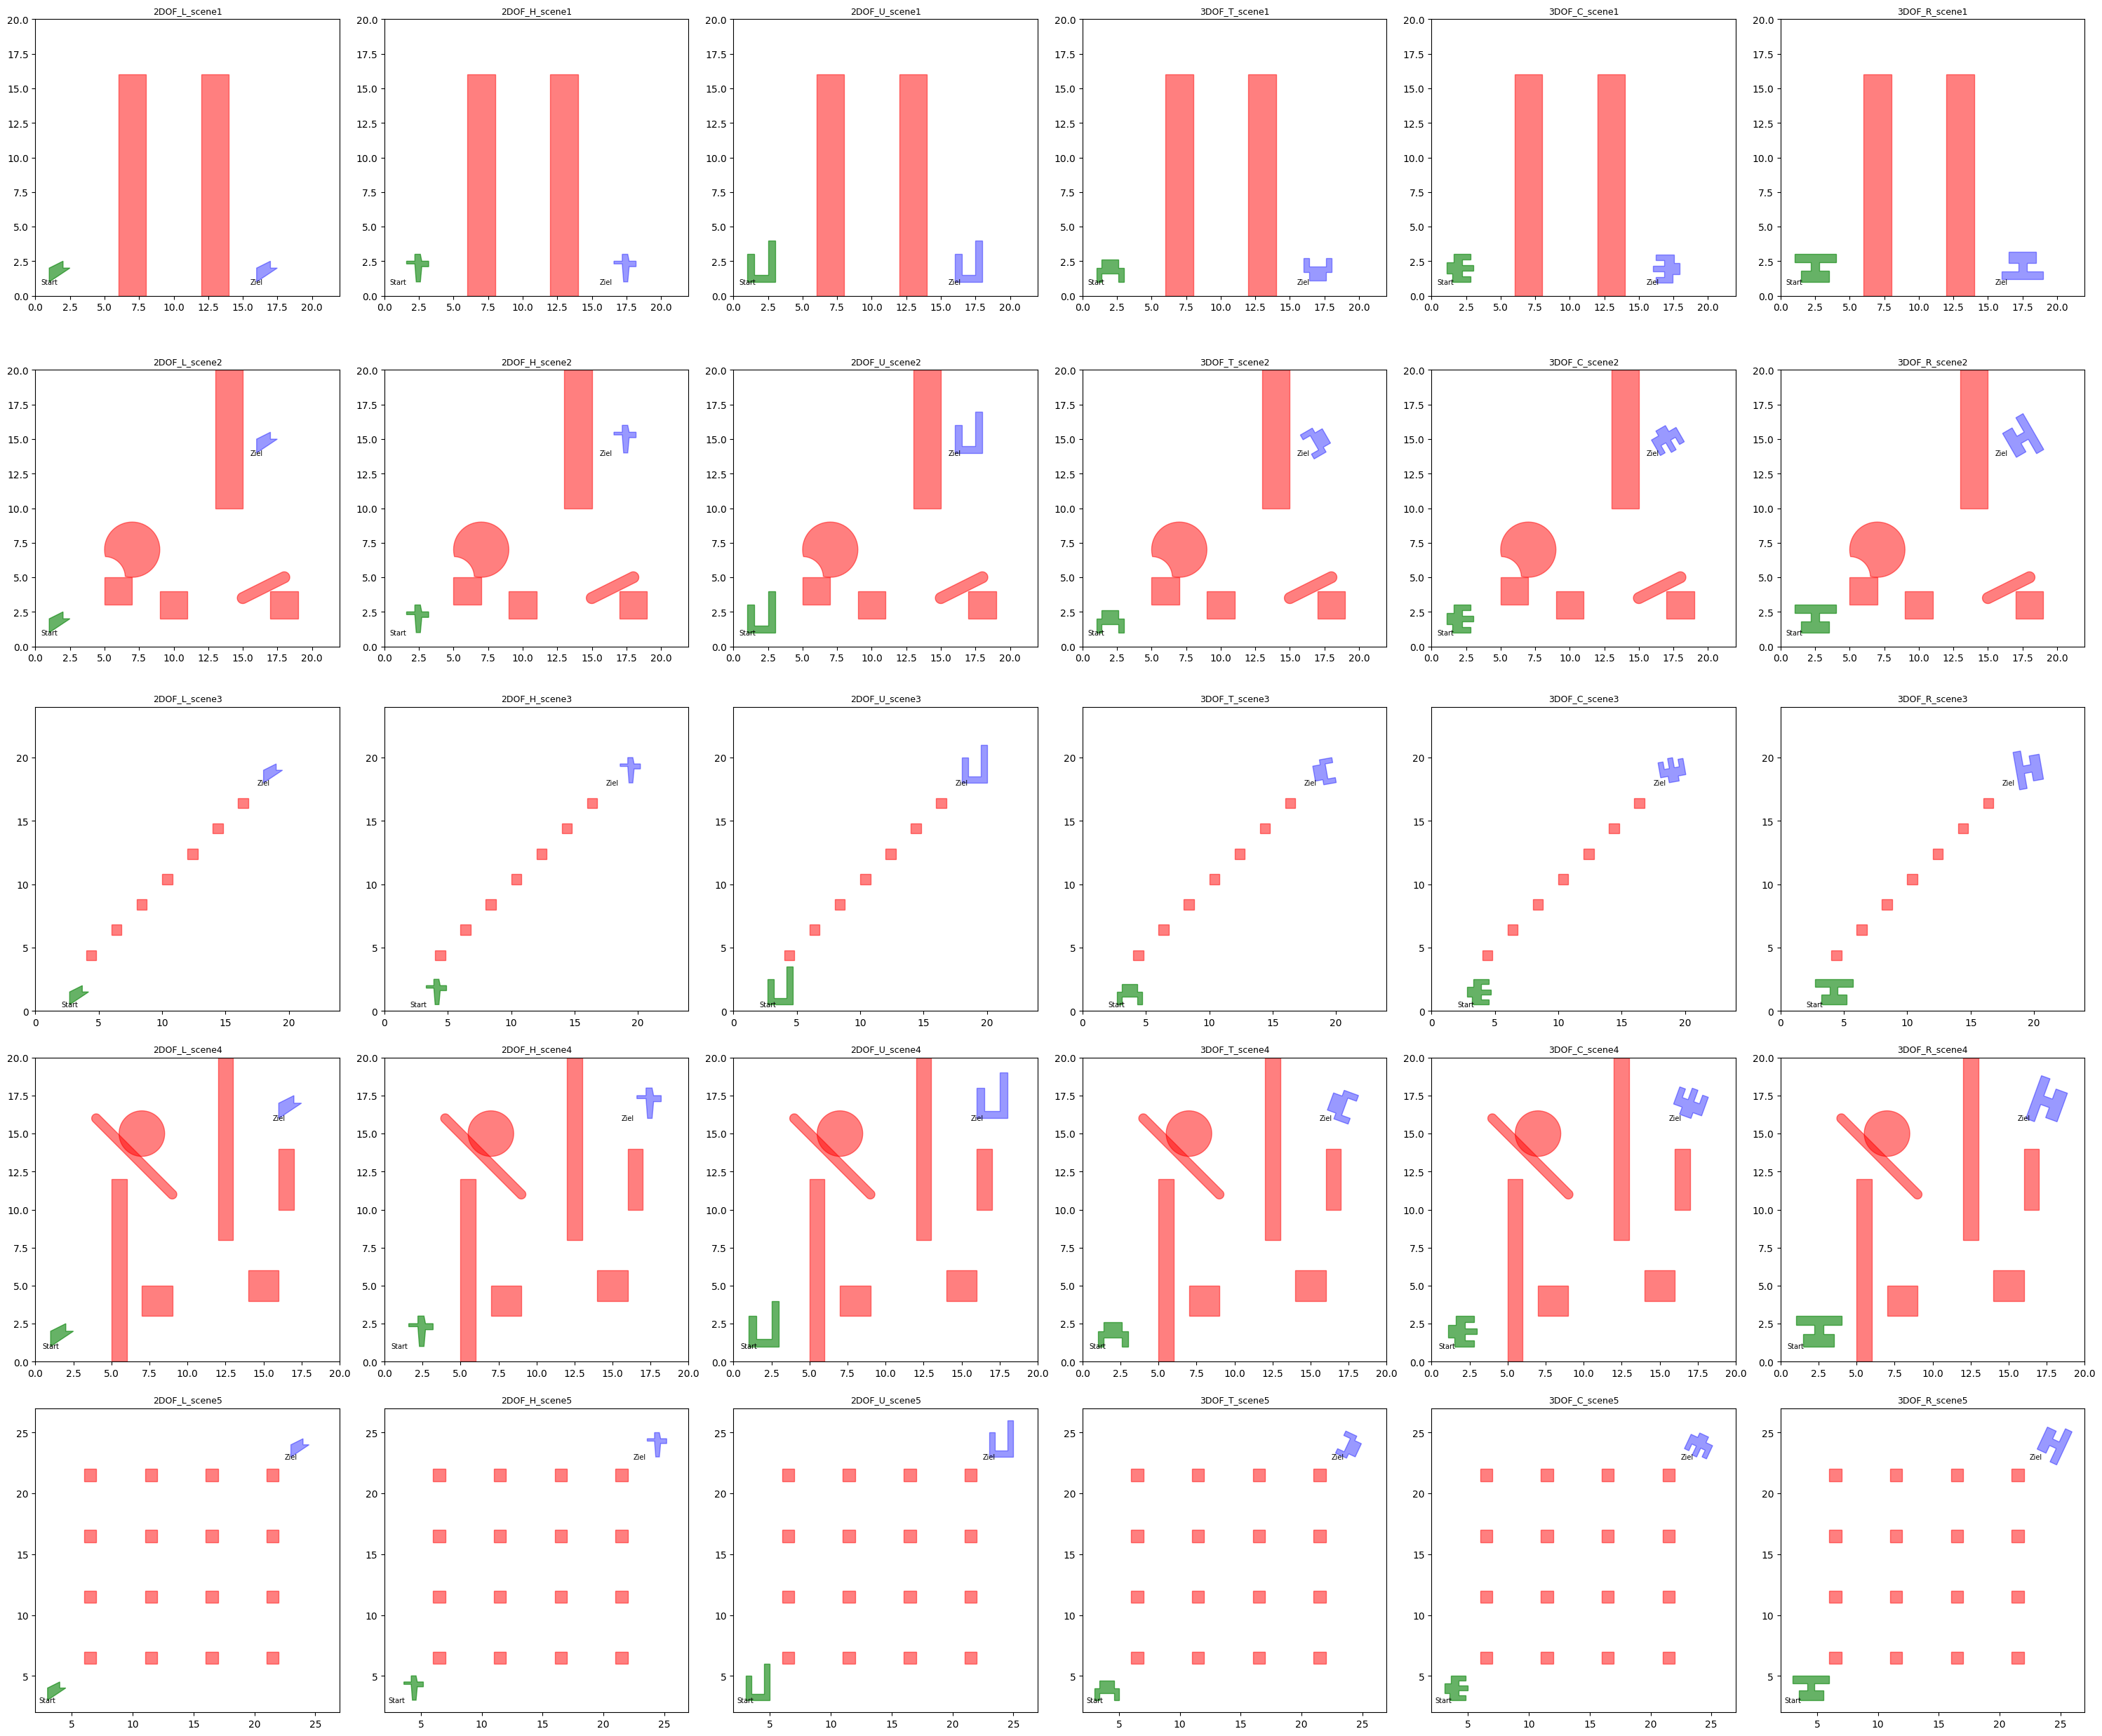

In [9]:
from IPTestSuiteMR import benchList
import matplotlib.pyplot as plt
from shapely.affinity import rotate, translate
import math

# Benchmark-Anzahl und Layout
n = len(benchList)
cols = 6
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for idx, benchmark in enumerate(benchList):
    ax = axes[idx]
    checker = benchmark.collisionChecker
    scene = checker.scene
    robot_shape = checker.robot_shape
    limits = checker.limits
    start = benchmark.startList[0]
    goal = benchmark.goalList[0]

    ax.set_xlim(*limits[0])
    ax.set_ylim(*limits[1])
    ax.set_aspect("equal")
    ax.set_title(f"{benchmark.name}", fontsize=9)

    # Hindernisse
    for obs in scene.values():
        if hasattr(obs, 'exterior'):
            x, y = obs.exterior.xy
            ax.fill(x, y, color="red", alpha=0.5)

    # Startposition
    if len(start) == 3:
        r_start = translate(rotate(robot_shape, start[2], origin="centroid"), xoff=start[0], yoff=start[1])
    else:
        r_start = translate(robot_shape, xoff=start[0], yoff=start[1])
    ax.fill(*r_start.exterior.xy, color="green", alpha=0.6)
    ax.text(start[0], start[1], "Start", ha="center", va="center", fontsize=7)

    # Zielposition
    if len(goal) == 3:
        r_goal = translate(rotate(robot_shape, goal[2], origin="centroid"), xoff=goal[0], yoff=goal[1])
    else:
        r_goal = translate(robot_shape, xoff=goal[0], yoff=goal[1])
    ax.fill(*r_goal.exterior.xy, color="blue", alpha=0.4)
    ax.text(goal[0], goal[1], "Ziel", ha="center", va="center", fontsize=7)

# Leere Achsen entfernen
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [15]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib as mpl
from IPython.display import HTML, display
from tqdm.notebook import tqdm
from IPBasicPRM import BasicPRM
from IPLazyPRM import LazyPRM  # Optional, falls später benötigt
from IPTestSuiteMR import benchList
from HelperFunction import (
    transform_robot,
    interpolate_path,
    compute_prm_path,
    plot_configuration_space,
    plot_work_space,
    make_animation,
    make_init_func,
    make_animate_func,
    animate_saved_result
)


mpl.rcParams['animation.embed_limit'] = 200
max_attempts = 10




BasicPRM

In [ ]:
config_basic = {'radius': 99.0, 'numNodes': 1000}
bench_range_basic = [benchList[23]]
  # oder eine andere Teilmenge


for idx, benchmark in enumerate(bench_range_basic):
    start = benchmark.startList[0]
    goal = benchmark.goalList[0]
    dof = len(start)
    path_ids = []

    for attempt in tqdm(range(1, max_attempts + 1), desc=f"BasicPRM Benchmark {idx+1}/{len(bench_range_basic)}"):
        path_ids, graph = compute_prm_path(BasicPRM, benchmark.collisionChecker, start, goal, config_basic)
        if path_ids:
            print(f"✔️ BasicPRM Benchmark {idx}: Pfad gefunden nach {attempt} Versuchen.")
            break
    if not path_ids:
        print(f"❌ BasicPRM Benchmark {idx}: Kein Pfad nach {max_attempts} Versuchen.")
        continue

    path = [graph.nodes[n]['pos'] for n in path_ids]
    interp = interpolate_path(path)
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d') if dof == 3 else fig.add_subplot(1, 2, 1)
    ax1.set_title('Konfigurationsraum (BasicPRM)')
    if dof == 3:
        coord1 = ax1.text2D(0.02, 0.95, '', transform=ax1.transAxes, fontsize=12,
                            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    else:
        coord1 = ax1.text(0.02, 0.95, '', transform=ax1.transAxes, fontsize=12,
                          verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title('Arbeitsraum (BasicPRM)')
    coord2 = ax2.text(0.02, 0.95, '', transform=ax2.transAxes, fontsize=12,
                      verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    robot_dot = plot_configuration_space(ax1, graph, path, start, goal, dof, benchmark.collisionChecker)
    robot_patch = plot_work_space(ax2, benchmark.collisionChecker.scene,
                                   benchmark.collisionChecker.robot_shape,
                                   start, goal, benchmark.collisionChecker)

    init = make_init_func(robot_patch, robot_dot, coord1, coord2, start, benchmark.collisionChecker.robot_shape, dof)
    animate = make_animate_func(robot_patch, robot_dot, coord1, coord2, interp, benchmark.collisionChecker.robot_shape, dof)


    ani = make_animation(fig, init, animate, len(interp))
    display(HTML(ani.to_jshtml()))
    plt.close(fig)


LazyPRM

In [ ]:

bench_range_lazy = benchList


config_lazy = {'initialRoadmapSize': 200, 'updateRoadmapSize': 50,
               'kNearest': 10, 'maxIterations': 50}

for idx, benchmark in enumerate(bench_range_lazy):
    start = benchmark.startList[0]
    goal  = benchmark.goalList[0]
    dof   = len(start)
    path_ids = []

    for attempt in tqdm(range(1, max_attempts + 1), desc=f"LazyPRM Benchmark {idx+1}/{len(bench_range_lazy)}"):
        path_ids, graph = compute_prm_path(LazyPRM, benchmark.collisionChecker, start, goal, config_lazy)
        if path_ids:
            print(f"✔️ LazyPRM Benchmark {idx}: Pfad gefunden nach {attempt} Versuchen.")
            break
    if not path_ids:
        print(f"❌ LazyPRM Benchmark {idx}: Kein Pfad nach {max_attempts} Versuchen.")
        continue

    path = [graph.nodes[n]['pos'] for n in path_ids]
    interp = interpolate_path(path)
    fig = plt.figure(figsize=(14,7))
    ax1 = fig.add_subplot(1,2,1, projection='3d') if dof==3 else fig.add_subplot(1,2,1)
    ax1.set_title('Konfigurationsraum (LazyPRM)')
    if dof == 3:
        coord1 = ax1.text2D(0.02, 0.95, '', transform=ax1.transAxes, fontsize=12,
                             verticalalignment='top', bbox=dict(facecolor='white',alpha=0.7))
    else:
        coord1 = ax1.text(0.02, 0.95, '', transform=ax1.transAxes, fontsize=12,
                          verticalalignment='top', bbox=dict(facecolor='white',alpha=0.7))
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('Arbeitsraum (LazyPRM)')
    coord2 = ax2.text(0.02, 0.95, '', transform=ax2.transAxes, fontsize=12,
                      verticalalignment='top', bbox=dict(facecolor='white',alpha=0.7))
    robot_dot = plot_configuration_space(ax1, graph, path, start, goal, dof, benchmark.collisionChecker)
    robot_patch = plot_work_space(ax2, benchmark.collisionChecker.scene,
                                   benchmark.collisionChecker.robot_shape,
                                   start, goal, benchmark.collisionChecker)

    init = make_init_func(robot_patch, robot_dot, coord1, coord2, start, benchmark.collisionChecker.robot_shape, dof)
    animate = make_animate_func(robot_patch, robot_dot, coord1, coord2, interp, benchmark.collisionChecker.robot_shape, dof)


    ani = make_animation(fig, init, animate, len(interp))
    display(HTML(ani.to_jshtml()))
    plt.close(fig)


RRT

In [20]:
from IPRRT import RRTSimple
# ---------------------------------
# RRTSimple-Visualisierung mit Retries
# ---------------------------------

bench_range_rrt = [benchList[22]]


config_rrt = {'numberOfGeneratedNodes': 900, 'testGoalAfterNumberOfNodes': 10}

for idx, benchmark in enumerate(bench_range_rrt):
    start = benchmark.startList[0]
    goal  = benchmark.goalList[0]
    dof   = len(start)
    path_ids = []

    for attempt in tqdm(range(1, max_attempts + 1), desc=f"RRT Benchmark {idx+1}/{len(bench_range_rrt)}"):
        path_ids, graph = compute_prm_path(RRTSimple, benchmark.collisionChecker, start, goal, config_rrt)
        if path_ids:
            print(f"✔️ RRT Benchmark {idx}: Pfad gefunden nach {attempt} Versuchen.")
            break
    if not path_ids:
        print(f"❌ RRT Benchmark {idx}: Kein Pfad oder Fehler nach {max_attempts} Versuchen.")
        continue

    path = [graph.nodes[n]['pos'] for n in path_ids]
    interp = interpolate_path(path)
    fig = plt.figure(figsize=(14,7))
    ax1 = fig.add_subplot(1,2,1, projection='3d') if dof==3 else fig.add_subplot(1,2,1)
    ax1.set_title('Konfigurationsraum (RRT)')
    if dof == 3:
        coord1 = ax1.text2D(0.02, 0.95, '', transform=ax1.transAxes, fontsize=12,
                             verticalalignment='top', bbox=dict(facecolor='white',alpha=0.7))
    else:
        coord1 = ax1.text(0.02, 0.95, '', transform=ax1.transAxes, fontsize=12,
                          verticalalignment='top', bbox=dict(facecolor='white',alpha=0.7))
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('Arbeitsraum (RRT)')
    coord2 = ax2.text(0.02, 0.95, '', transform=ax2.transAxes, fontsize=12,
                      verticalalignment='top', bbox=dict(facecolor='white',alpha=0.7))
    robot_dot = plot_configuration_space(ax1, graph, path, start, goal, dof, benchmark.collisionChecker)
    robot_patch = plot_work_space(ax2, benchmark.collisionChecker.scene,
                                   benchmark.collisionChecker.robot_shape,
                                   start, goal, benchmark.collisionChecker)

    init = make_init_func(robot_patch, robot_dot, coord1, coord2, start, benchmark.collisionChecker.robot_shape, dof)
    animate = make_animate_func(robot_patch, robot_dot, coord1, coord2, interp, benchmark.collisionChecker.robot_shape, dof)


    ani = make_animation(fig, init, animate, len(interp))
    display(HTML(ani.to_jshtml()))
    plt.close(fig)

RRT Benchmark 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

❌ RRT Benchmark 0: Kein Pfad oder Fehler nach 10 Versuchen.


d) Vergleichen Sie die Planungsverfahren hinsichtlich Suchzeit, Größe Roadmap, Anzahl Punkte im Pfad, Länge des Pfades. 

In [24]:
import pandas as pd


from IPRRT import RRTSimple
from IPTestSuiteMR import benchList
from IPBasicPRM import BasicPRM
from IPLazyPRM import LazyPRM
from IPRRT import RRTSimple
import numpy as np
from HelperFunction import run_benchmark


# Maximale Anzahl an Versuchen pro Benchmark
max_attempts = 10

# BasicPRM-Konfiguration
config_basic = {
    'radius': 50.0,
    'numNodes': 300
}

# LazyPRM-Konfiguration
config_lazy = {
    'initialRoadmapSize': 900,
    'updateRoadmapSize': 100,
    'kNearest': 20,
    'maxIterations': 50
}

# RRT-Konfiguration
config_rrt = {
    'numberOfGeneratedNodes': 1000,
    'testGoalAfterNumberOfNodes': 10
}

# -------------------------------
# Benchmark-Durchläufe
# -------------------------------

bench_range_basic = benchList
bench_range_lazy = benchList
bench_range_rrt = benchList

results = []
results += run_benchmark(BasicPRM, "BasicPRM", config_basic, bench_range_basic, max_attempts)
results += run_benchmark(LazyPRM, "LazyPRM", config_lazy, bench_range_lazy, max_attempts)
results += run_benchmark(RRTSimple, "RRTSimple", config_rrt, bench_range_rrt, max_attempts)

from IPython.display import display

df_results = pd.DataFrame(results)
df_results = df_results[['Planner', 'Benchmark', 'Time [s]', 'Roadmap Size', 'Path Points', 'Path Length']]
df_results.to_csv('benchmark_results.csv', index=False)

display(df_results)


🔍 Starte Benchmarks für BasicPRM...


BasicPRM Benchmarks:   0%|          | 0/30 [00:00<?, ?it/s]

🔍 Starte Benchmarks für LazyPRM...


LazyPRM Benchmarks:   0%|          | 0/30 [00:00<?, ?it/s]

🔍 Starte Benchmarks für RRTSimple...


RRTSimple Benchmarks:   0%|          | 0/30 [00:00<?, ?it/s]

,Planner,Benchmark,Time [s],Roadmap Size,Path Points,Path Length
0,BasicPRM,0,2.192,302,6,49.748
1,BasicPRM,1,1.873,302,7,46.378
2,BasicPRM,2,4.177,302,9,52.063
3,BasicPRM,3,2.174,302,18,554.757
4,BasicPRM,4,3.281,302,15,492.518
...,...,...,...,...,...,...
85,RRTSimple,25,0.342,51,9,44.172
86,RRTSimple,26,0.093,11,7,41.461
87,RRTSimple,27,1.365,151,9,329.331
88,RRTSimple,28,7.085,11,6,441.907


Durchschnittswerte je Planungsverfahren:


,Time [s],Roadmap Size,Path Points,Path Length
Planner,,,,
BasicPRM,12.043000,302.000000,12.000000,281.002000
LazyPRM,26.683000,831.733000,23.833000,139.639000
RRTSimple,1.162000,169.600000,8.467000,165.556000


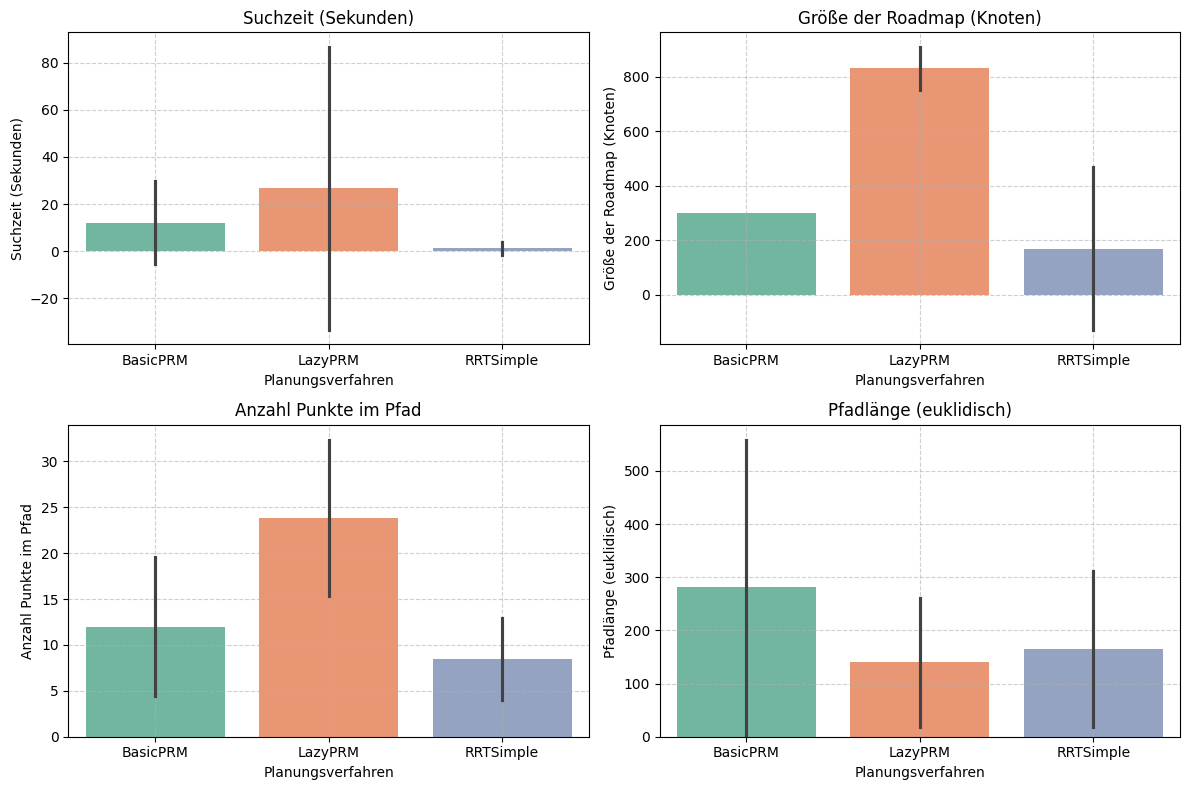

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# -------------------------------------
# 1. Mittelwert-Tabelle mit Markierung
# -------------------------------------
df_results = pd.read_csv('benchmark_results.csv')
pivot_avg = df_results.groupby("Planner").mean(numeric_only=True).round(3)
pivot_avg = pivot_avg[['Time [s]', 'Roadmap Size', 'Path Points', 'Path Length']]

def highlight_min_max(df):
    return df.style.apply(lambda x: [
        'background-color: green' if v == x.min() else
        'background-color: coral' if v == x.max() else ''
        for v in x
    ], axis=0)

print("Durchschnittswerte je Planungsverfahren:")
display(highlight_min_max(pivot_avg))

# -------------------------------------
# 2. 2x2 Balkendiagramme nebeneinander
# -------------------------------------
metrics = ['Time [s]', 'Roadmap Size', 'Path Points', 'Path Length']
titles = ['Suchzeit (Sekunden)', 'Größe der Roadmap (Knoten)',
          'Anzahl Punkte im Pfad', 'Pfadlänge (euklidisch)']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (metric, title) in enumerate(zip(metrics, titles)):
    sns.barplot(
        data=df_results,
        x='Planner',
        y=metric,
        hue='Planner',
        errorbar='sd',
        palette='Set2',
        dodge=False,
        ax=axes[i]
    )
    axes[i].set_title(title)
    axes[i].set_xlabel("Planungsverfahren")
    axes[i].set_ylabel(title)
    axes[i].grid(True, linestyle='--', alpha=0.6)
    legend = axes[i].get_legend()
    if legend is not None:
        legend.remove()


plt.tight_layout()
plt.show()


In [ ]:
animate_saved_result(results, selected_benchmark=1, selected_planner="RRTSimple")



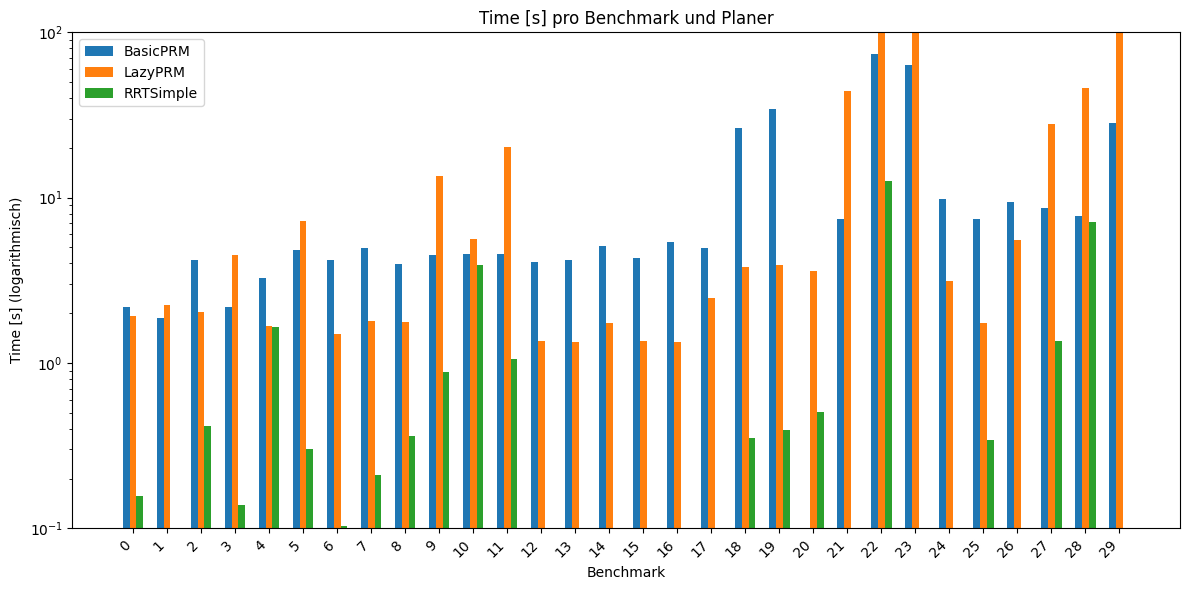

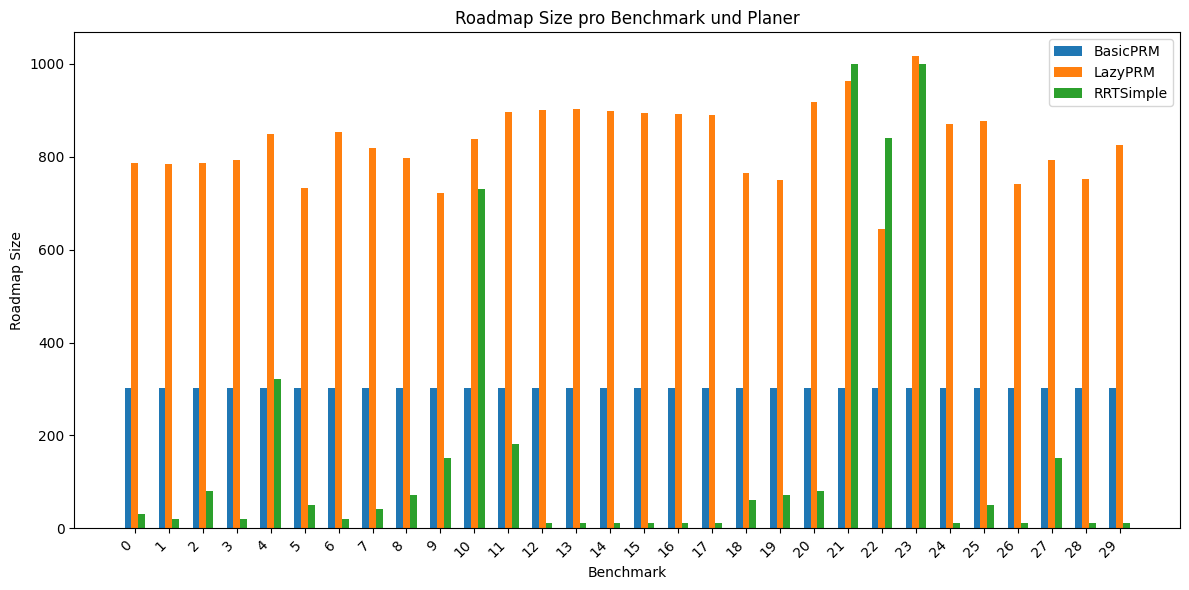

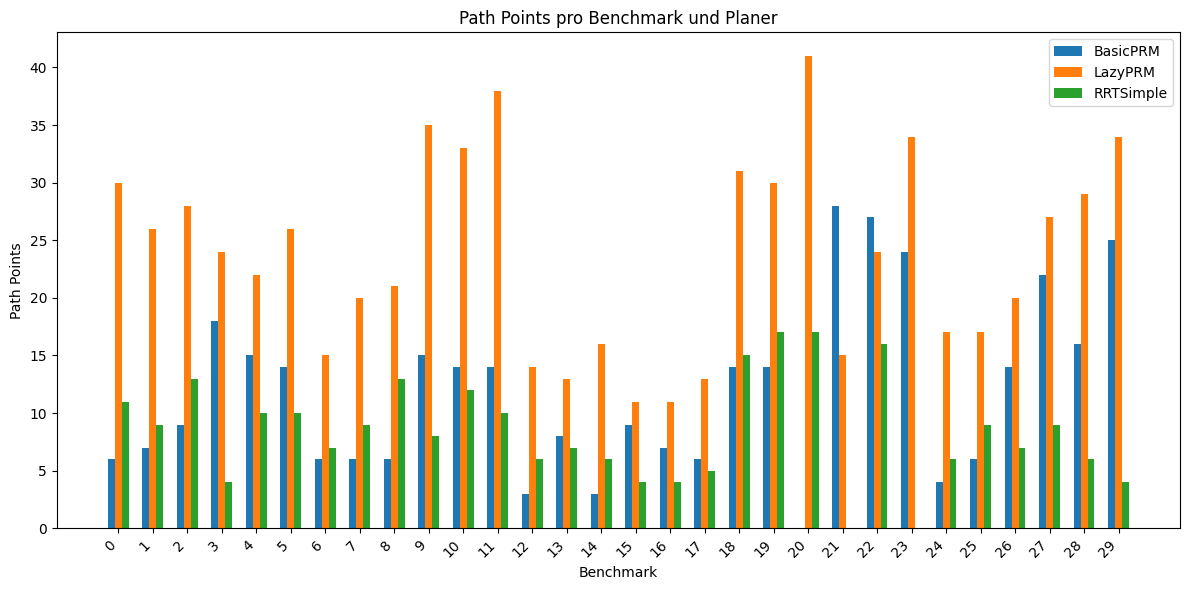

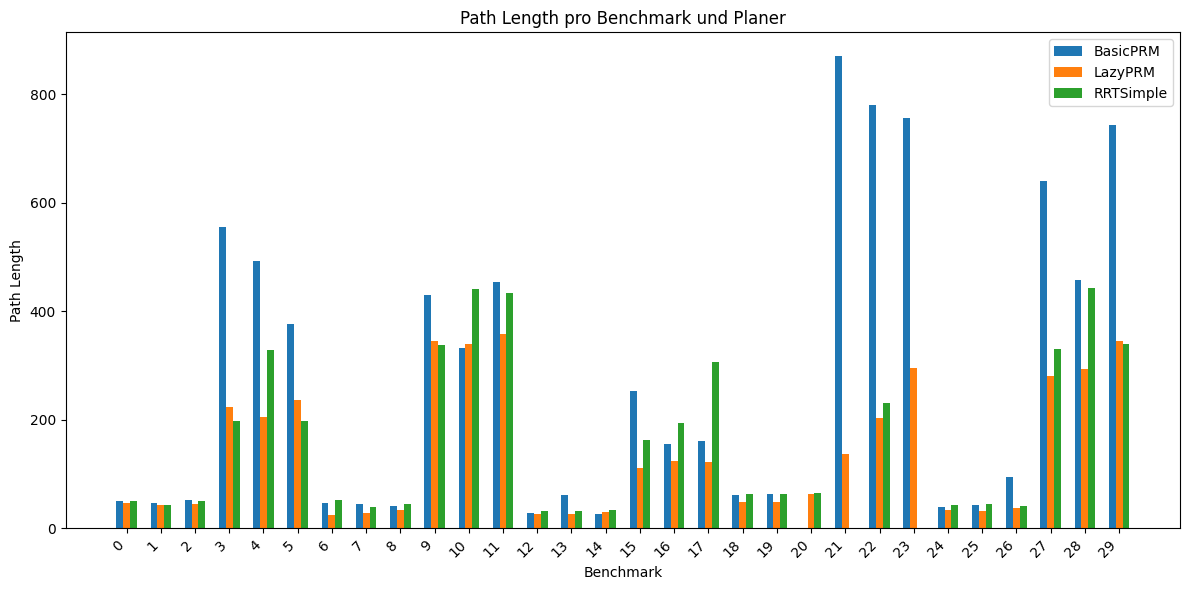

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV laden
df_results = pd.read_csv('benchmark_results.csv')

metrics = ['Time [s]', 'Roadmap Size', 'Path Points', 'Path Length']
planners = df_results['Planner'].unique()
benchmarks = df_results['Benchmark'].unique()

for metric in metrics:
    plt.figure(figsize=(12, 6))
    x = range(len(benchmarks))
    width = 0.2

    for i, planner in enumerate(planners):
        values = []
        for benchmark in benchmarks:
            subset = df_results[(df_results['Planner'] == planner) & (df_results['Benchmark'] == benchmark)]
            mean_value = subset[metric].mean() if not subset.empty else 0.001  # Vermeidet log(0)
            values.append(mean_value)

        offset = [xi + (i - 1) * width for xi in x]
        plt.bar(offset, values, width=width, label=planner)

    plt.title(f'{metric} pro Benchmark und Planer')
    plt.xlabel('Benchmark')
    plt.ylabel(metric)
    plt.xticks(ticks=x, labels=benchmarks, rotation=45, ha='right')

    # Logarithmische y-Achse für 'Time [s]'
    if metric == 'Time [s]':
        plt.yscale('log')
        plt.ylim(1e-1, 100)  # z.B. 1ms bis 10 Sekunden
        plt.ylabel('Time [s] (logarithmisch)')


    plt.legend()
    plt.tight_layout()
    plt.show()
